In [163]:
import logging
from piny import YamlLoader
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import pandas as pd
import seaborn as sns

In [164]:
sys.path.append("../src")

In [165]:
from utils import setup_logging
from data.loader.football_data import FootballData
from data.feature import EloRatingGenerator, WinStreakGenerator, GapRatingGenerator, PiRatingGenerator, OverUnderGenerator
from models.classifier_comparison import ClassifierComparison
from strategy import KellyCriterionStrategy, FixedFractionalStrategy, FractionalKellyCriterionStrategy, ConfidenceThresholdStrategy, DynamicFractionalKellyCriterionStrategy

### Setting up Environment 

In [166]:
print("Loading config file...")
config = YamlLoader(path="../src/config/config.yaml").load()
FOOTBALL_DATA_CONFIG = config["data"]
COLUMNS = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA']

print("Loading football data...")
football_dataset = FootballData.load(**FOOTBALL_DATA_CONFIG, columns=COLUMNS)

Loading config file...
Loading football data...


/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future ver

In [167]:
football_dataset.divisions.keys()

dict_keys(['E0', 'E1', 'SP1'])

In [168]:
football_dataset.divisions["E0"].dataframe

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HS,...,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,Season
0,E0,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,11,...,2.00,3.30,3.70,2.10,3.30,3.30,1.95,3.65,4.27,2015-2016
1,E0,2015-08-08,Chelsea,Swansea,2,2,D,2,1,11,...,1.40,4.75,9.00,1.33,4.80,8.30,1.39,4.92,10.39,2015-2016
2,E0,2015-08-08,Everton,Watford,2,2,D,0,1,10,...,1.70,3.50,5.00,1.70,3.60,4.70,1.70,3.95,5.62,2015-2016
3,E0,2015-08-08,Leicester,Sunderland,4,2,H,3,0,19,...,2.00,3.30,3.75,2.00,3.30,3.60,1.99,3.48,4.34,2015-2016
4,E0,2015-08-08,Man United,Tottenham,1,0,H,1,0,9,...,1.65,4.00,5.50,1.65,3.60,5.10,1.65,4.09,5.90,2015-2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,E0,2023-05-28,Everton,Bournemouth,1,0,H,0,0,13,...,1.47,4.50,6.50,1.45,4.60,7.25,1.50,4.63,6.54,2022-2023
3036,E0,2023-05-28,Leeds,Tottenham,1,4,A,0,1,19,...,2.70,3.70,2.37,2.65,3.80,2.45,2.81,3.93,2.36,2022-2023
3037,E0,2023-05-28,Leicester,West Ham,2,1,H,1,0,13,...,1.95,3.80,3.50,1.95,3.85,3.60,1.95,4.02,3.64,2022-2023
3038,E0,2023-05-28,Man United,Fulham,2,1,H,1,1,21,...,1.51,4.60,5.75,1.53,4.50,5.75,1.53,4.65,5.84,2022-2023


### Generating the features 

In [169]:
elo_rating_generator = EloRatingGenerator()
win_streak_generator = WinStreakGenerator()
gap_rating_generator = GapRatingGenerator(input_features=[("FTHG", "FTAG"), ("HC", "AC")])
pi_rating_generator = PiRatingGenerator()

football_dataset.compute_features([elo_rating_generator, win_streak_generator, gap_rating_generator, pi_rating_generator])

label_encoder = LabelEncoder()
feature_columns = ['HomeEloBefore', 'AwayEloBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'HomeGapAttackBefore', 
                'HomeGapDefendBefore', 'AwayGapAttackBefore', 'AwayGapDefendBefore','HomeStreakBefore', 'AwayStreakBefore', 'HomePiBefore', 'AwayPiBefore']

# division = football_dataset.divisions['E0']
# division = football_dataset.divisions['E1']
division = football_dataset.divisions['SP1']

### Prepairing the dataframe

In [170]:
df = division.dataframe
# df = pd.concat([item.dataframe for item in football_dataset.divisions.values()])

df = df.dropna(subset=feature_columns)
df['FTR'] = label_encoder.fit_transform(df['FTR'])

# Shuffle the dataset
data = df.sample(frac=1, random_state=42)

# Create validation and test sets
validation_set = data[data['Season'] == '2021-2022']
test_set = data[data['Season'] == '2022-2023']

# Create the training set
train_set = data[~data['Season'].isin(['2021-2022', '2022-2023'])]
# model_features = ['HomePiBefore', 'AwayPiBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA']
# model_features = ['HomeEloBefore', 'AwayEloBefore','HomeStreakBefore', 'AwayStreakBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']
model_features = ['HomeGapAttackBefore', 'HomeGapDefendBefore', 'AwayGapAttackBefore', 'AwayGapDefendBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA']
# model_features = ['HomeGapAttackBefore', 'HomeGapDefendBefore', 'AwayGapAttackBefore', 'AwayGapDefendBefore', 'HomePiBefore', 'AwayPiBefore', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']

X_train, y_train = train_set[model_features], train_set['FTR']
X_test, y_test = test_set[model_features], test_set['FTR']
X_val, y_val = validation_set[model_features], validation_set['FTR']

/var/folders/7r/wl3x6jwx2912f_7n3sv274kh0000gn/T/ipykernel_29160/3376301796.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FTR'] = label_encoder.fit_transform(df['FTR'])


In [171]:
print("Size of the dataset:")
print("Training \t[2015-2021] |", len(train_set))
print("Validation \t[2021-2022] | ", len(validation_set))
print("Testing \t[2022-2023] | ", len(test_set))

Size of the dataset:
Training 	[2015-2021] | 2274
Validation 	[2021-2022] |  379
Testing 	[2022-2023] |  380


### Building and comparing models

In [172]:
from sklearn.metrics import log_loss
import numpy as np

### Use of Log-loss for evaluation of classification models

In the context of sports betting, where we are predicting the outcomes of football matches, log-loss serves as an ideal performance metric for several reasons. Primarily, in a betting environment, the prediction of the outcome is not simply a binary or multi-class problem, but rather the confidence in the predicted outcome also holds significant importance. This is because the stakes on a bet are often determined by the confidence in the predicted outcome.

The log-loss metric precisely quantifies this by evaluating not just the predicted class, but the probabilities associated with each predicted class. By doing so, it provides a more comprehensive view of the model's performance by considering both the accuracy of the predictions and the confidence in each prediction.

One of the key advantages of log-loss in the sports betting context is that it promotes well-calibrated probabilities. In other words, it rewards the models that are able to correctly estimate the true underlying probabilities of the outcomes. This attribute is critical in betting where the profitability of a betting strategy is not just determined by predicting the correct outcome, but also correctly estimating the odds.

Furthermore, log-loss penalises models that make confident yet incorrect predictions. This characteristic is particularly beneficial in a betting scenario, as overconfident predictions can lead to large losses. A model that is less confident and predicts probabilities close to 0.5 for all outcomes will often achieve a better log-loss score than a model that makes confident but incorrect predictions.

Therefore, when developing models for a betting strategy, using log-loss as the optimisation metric is an appropriate choice. It encourages the model to make well-calibrated and cautious predictions, which aligns with the overall goal of maximising the profitability of the betting strategy.

/Users/charaka/opt/anaconda3/envs/digital_finance/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/charaka/opt/anaconda3/envs/digital_finance/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


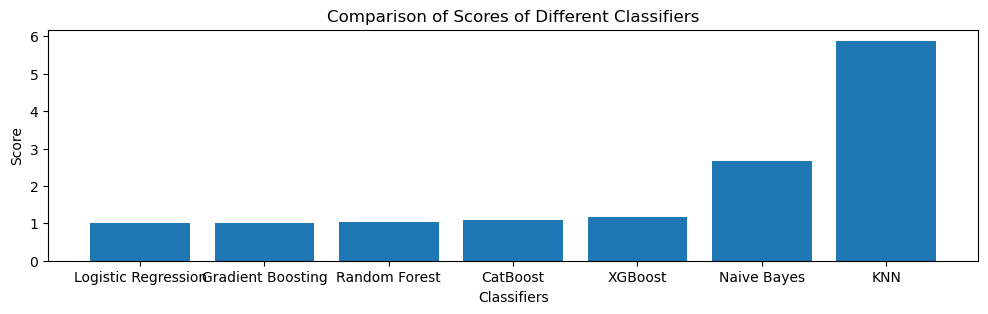

Scores: {'Random Forest': 1.0255466177402517, 'KNN': 5.882799051481124, 'Logistic Regression': 0.9987114545812298, 'Naive Bayes': 2.6592742016573334, 'Gradient Boosting': 1.002512831657805, 'XGBoost': 1.1784660025676583, 'CatBoost': 1.0943681318412113}
Best classifier: Logistic Regression | Score: 1.00


In [173]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    # 'SVC': make_pipeline(StandardScaler(), SVC()),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=False, n_estimators=100),
    # 'LightGBM': lgb.LGBMClassifier(),
}

classifier_comparison = ClassifierComparison(classifiers)
labels = np.unique(y_val)
classifier_comparison.fit_and_score(X_train, y_train, X_val, y_val, score_func=log_loss, labels=labels)
classifier_comparison.plot_scores()
best_classifier = classifier_comparison.best_classifier(greater_is_better=False)
print(f"Scores: {classifier_comparison.scores}")
print(f"Best classifier: {best_classifier} | Score: {classifier_comparison.scores[best_classifier]:.2f}")

Text(0.5, 1.0, 'Random Forest Feature Importance')

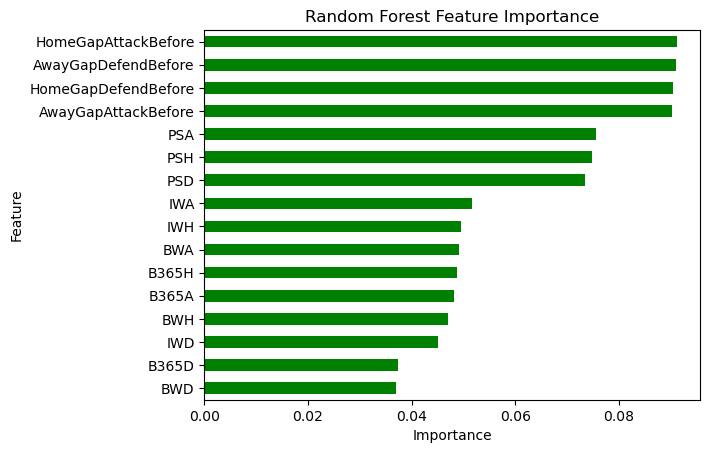

In [116]:
global_importances = pd.Series(classifiers['Random Forest'].feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Create a GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42)

# Use log loss as the scoring method
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (negative log loss): ", grid_search.best_score_)

# Evaluate on the validation set
y_pred_proba = grid_search.best_estimator_.predict_proba(X_val)
loss = log_loss(y_val, y_pred_proba)
print("Log loss on validation set: ", loss)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score (negative log loss):  -1.0394764181869747
Log loss on validation set:  1.0337208344893898


#### ⚠️ **Lower log-loss the better the model**

Starting bankroll: 1000
Ending bankroll: 32.12802388519139


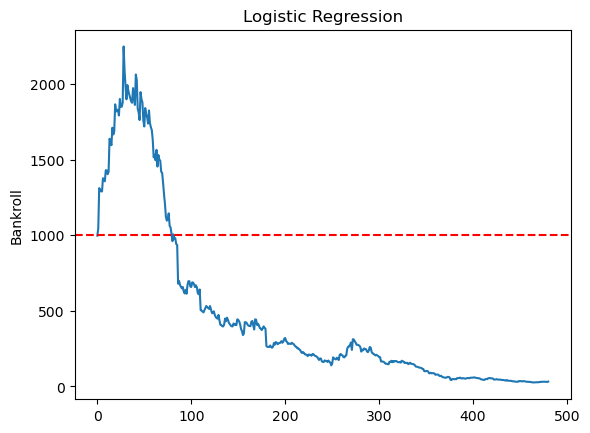

In [147]:
classifier_name = best_classifier
classifier = classifiers[classifier_name]
# classifier = grid_search.best_estimator_

strategy = KellyCriterionStrategy(label_encoder)
# strategy = FixedFractionalStrategy(label_encoder, fraction=0.05)
# strategy = ConfidenceThresholdStrategy(label_encoder, confidence_threshold=0.7, bet_size=0.1)
# strategy = FractionalKellyCriterionStrategy(label_encoder, fraction=0.15)
# strategy = DynamicFractionalKellyCriterionStrategy(label_encoder, min_fraction=0.15, max_fraction=0.35)
print(f'Starting bankroll: {strategy.bankroll}')

# Run the strategy
strategy.run(X_test, y_test, classifier)
print(f'Ending bankroll: {strategy.bankroll}')

sns.lineplot(data=strategy.history, x=strategy.history.index, y='Bankroll').set_title(classifier_name)
plt.axhline(1000, color='r', linestyle='--')
plt.show()

In [79]:
strategy.history.head(5)

,Match,Bet,Stake,Outcome,ProfitLoss,Bankroll,Odds,Predicted Probability,Actual Probability
0,0,D,12.791434,Win,30.699441,1030.699441,3.40,0.303147,0.286611
1,1,H,51.764036,Win,57.458079,1088.157520,2.11,0.500354,0.460591
2,2,H,77.348008,Win,225.856183,1314.013703,3.92,0.308051,0.247933
3,3,A,26.411075,Loss,-26.411075,1287.602628,5.17,0.209635,0.187326
4,4,H,26.412373,Loss,-26.412373,1261.190255,3.42,0.306913,0.284561


In [103]:
strategy.history["Outcome"].value_counts()

Loss    236
Win     114
Name: Outcome, dtype: int64

In [104]:
strategy.metric_report()

{'Total Profit': 439.09246434155966,
 'Total Staked': 30492.169830712544,
 'Current Bankroll': 1439.092464341561,
 'Standard Deviation of Returns': 0.08426042207651638,
 'ROI': 0.4390924643415597,
 'Yield': 0.014400171151457176,
 'Win Rate': 0.32571428571428573,
 'Volatility': 151.3769564367193,
 'Sharpe Ratio': 0.04846962397726064,
 'Sortino Ratio': 0.132264787360173}

In [105]:
# TODO: Train, Validate & Test rolling window 
# TODO: Conditional probability for ML Models, odds fluctuating -> probability fluctuating (asumption of liquid markets)
# TODO: Regression other markets over/under 1.5 goals, over/under 2.5 goals (more liquid markets)
# TODO: Feature Importance
# TODO: Double poisson distribution 
# TODO: Bayseain method 
# TODO: Hidden Markov Model to get the goals using odds -> Poisson Model to test accuracy 

Running Logistic Regression...
Starting bankroll: 1000
Ending bankroll: 275.336499166843
{'Total Profit': -724.6635008331575, 'Total Staked': 7064.746722677706, 'Current Bankroll': 275.336499166843, 'Standard Deviation of Returns': 0.029072055221608134, 'ROI': -0.7246635008331576, 'Yield': -0.10257459032565189, 'Win Rate': 0.30612244897959184, 'Volatility': 22.57847503806999, 'Sharpe Ratio': -0.07627775207168509, 'Sortino Ratio': -13292136661182.39}
Running Gradient Boosting...
Starting bankroll: 1000
Ending bankroll: 600.3907897823362
{'Total Profit': -399.6092102176633, 'Total Staked': 9365.044802050834, 'Current Bankroll': 600.3907897823362, 'Standard Deviation of Returns': 0.028244793227224892, 'ROI': -0.3996092102176633, 'Yield': -0.04267029348649284, 'Win Rate': 0.34774436090225563, 'Volatility': 25.29419983826018, 'Sharpe Ratio': -0.020084878247078056, 'Sortino Ratio': -3265100837087.4023}
Running Random Forest...
Starting bankroll: 1000
Ending bankroll: 551.5607451907213
{'Tota

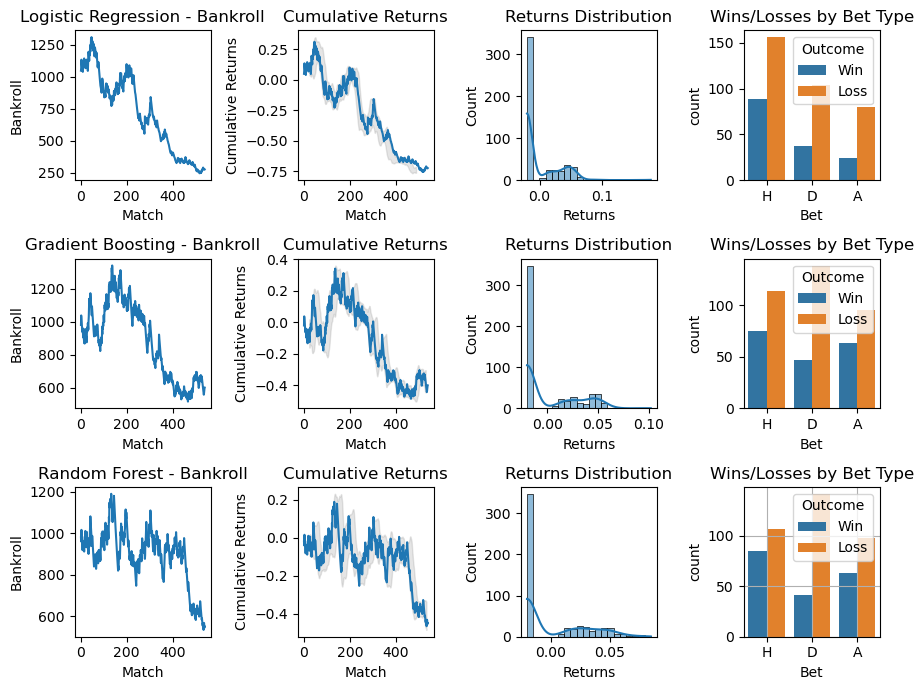

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

top_5_classifiers = classifier_comparison.top_n_classifiers(3, greater_is_better=False)
# Initialize a figure for the gridplot
fig, axs = plt.subplots(len(top_5_classifiers), 4, figsize=(9, 7))

# Run the strategy for each classifier and plot the results
for i, (name, classifier) in enumerate(top_5_classifiers.items()):
    # Initialize the Kelly Criterion Strategy
    print(f'Running {name}...')
    strategy = FixedFractionalStrategy(label_encoder, fraction=0.02)

    # Run the strategy
    strategy.run(X_test, y_test, classifier)
    print(f'Starting bankroll: {strategy.initial_bankroll}')
    print(f'Ending bankroll: {strategy.bankroll}')
    print(strategy.metric_report())

    history = strategy.history.copy()

    history["Returns"] = strategy.get_historical_returns()
    history['Cumulative Returns'] = (1 + history["Returns"]).cumprod() - 1

    # Calculate rolling mean and standard deviation
    history['Cumulative Returns Mean'] = history['Cumulative Returns'].rolling(window=25).mean()
    history['Cumulative Returns Std'] = history['Cumulative Returns'].rolling(window=25).std()

    # Calculate upper and lower bounds for 95% confidence interval
    history['Upper Bound'] = history['Cumulative Returns Mean'] + 1.96 * history['Cumulative Returns Std']
    history['Lower Bound'] = history['Cumulative Returns Mean'] - 1.96 * history['Cumulative Returns Std']

    running_max = np.maximum.accumulate(history['Cumulative Returns'])
    history['Drawdown'] = running_max - history['Cumulative Returns']

    bet_order = ['H', 'D', 'A']
    outcome_order = ['Win', 'Loss']
    
    # Plot the history
    sns.lineplot(data=history, x='Match', y='Bankroll', ax=axs[i][0]).set_title(f"{name} - Bankroll")
    sns.lineplot(data=history, x='Match', y='Cumulative Returns', ax=axs[i][1]).set_title("Cumulative Returns")
    axs[i][1].fill_between(history.index, history['Lower Bound'], history['Upper Bound'], color='gray', alpha=0.2)
    sns.histplot(data=history, x='Returns', bins=20, ax=axs[i][2], kde=True).set_title("Returns Distribution")
    sns.countplot(data=history, x='Bet', hue='Outcome', ax=axs[i][3], order=bet_order, hue_order=outcome_order).set_title("Wins/Losses by Bet Type")
    # sns.scatterplot(data=history, x='Predicted Probability', y='Actual Probability', ax=axs[i][4]).set_title("Predicted vs Actual Probability")
    # sns.lineplot(data=history, x='Match', y='Drawdown', ax=axs[i][4]).set_title(f"Drawdowns")

plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
top_5_classifiers

{'Logistic Regression': LogisticRegression(max_iter=500),
 'Gradient Boosting': GradientBoostingClassifier(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42)}

In [85]:
classifiers

{'Random Forest': RandomForestClassifier(random_state=42),
 'KNN': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 'Logistic Regression': LogisticRegression(max_iter=500),
 'Naive Bayes': GaussianNB(),
 'Gradient Boosting': GradientBoostingClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_cons

Running KC...
Starting bankroll: 1000
Ending bankroll: 454.52607944203766
{'Total Profit': -545.4739205579626, 'Total Staked': 13231.499987670537, 'Current Bankroll': 454.52607944203766, 'Standard Deviation of Returns': 0.059276438071305115, 'ROI': -0.5454739205579626, 'Yield': -0.04122540309611531, 'Win Rate': 0.3201663201663202, 'Volatility': 59.05705067633526, 'Sharpe Ratio': 3.450725406151116e-05, 'Sortino Ratio': 8.651748636641275e-05}
Running CT...
Starting bankroll: 1000
Ending bankroll: 920.6748492768043
{'Total Profit': -79.32515072319575, 'Total Staked': 826.5452665019814, 'Current Bankroll': 920.6748492768043, 'Standard Deviation of Returns': 0.07655611853871828, 'ROI': -0.07932515072319575, 'Yield': -0.09597193757930207, 'Win Rate': 0.625, 'Volatility': 80.6888812310365, 'Sharpe Ratio': -0.09960013837618553, 'Sortino Ratio': -448615191109077.94}
Running FKC...
Starting bankroll: 1000
Ending bankroll: 997.9512307182491
{'Total Profit': -2.0487692817521053, 'Total Staked': 74

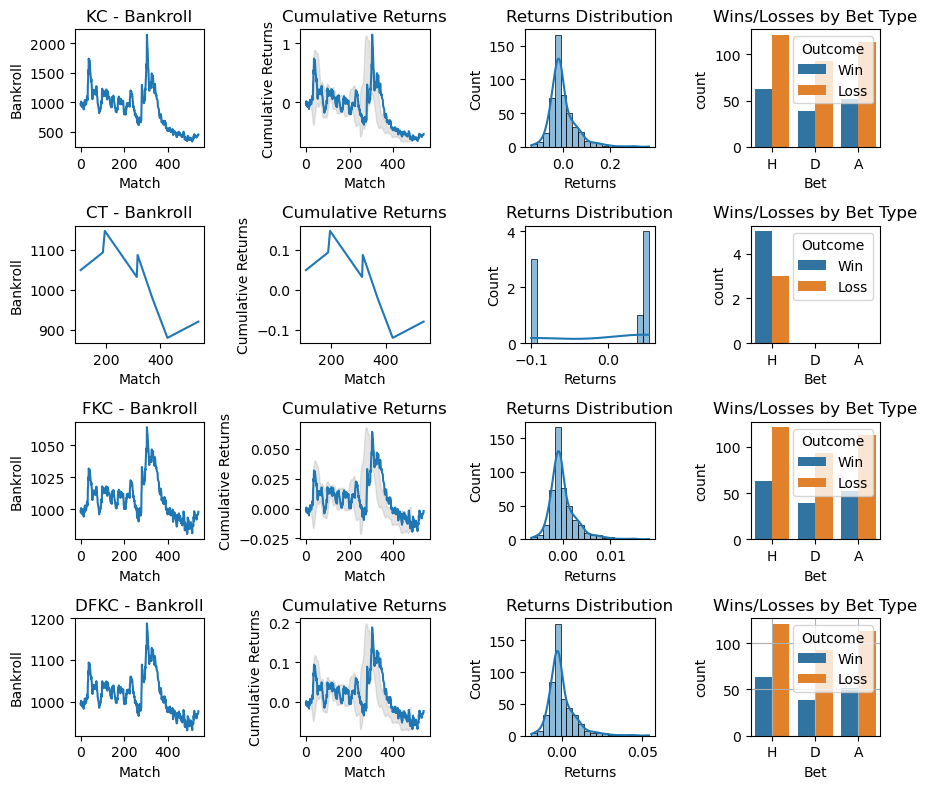

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

strategies = {
    "KC": KellyCriterionStrategy(label_encoder),
    "CT": ConfidenceThresholdStrategy(label_encoder, confidence_threshold=0.675, bet_size=0.1),
    "FKC": FractionalKellyCriterionStrategy(label_encoder, fraction=0.05),
    "DFKC": DynamicFractionalKellyCriterionStrategy(label_encoder, min_fraction=0.05, max_fraction=0.15)
}


# Initialize a figure for the gridplot
fig, axs = plt.subplots(len(strategies), 4, figsize=(9, 8))
classifier_name = 'Gradient Boosting'
classifier = grid_search.best_estimator_

# Run the strategy for each classifier and plot the results
for i, (name, strategy) in enumerate(strategies.items()):
    
    # Initialize the Kelly Criterion Strategy
    print(f'Running {name}...')
    
    # Run the strategy
    strategy.run(X_test, y_test, classifier)
    print(f'Starting bankroll: {strategy.initial_bankroll}')
    print(f'Ending bankroll: {strategy.bankroll}')
    print(strategy.metric_report())

    history = strategy.history.copy()

    history["Returns"] = strategy.get_historical_returns()
    history['Cumulative Returns'] = (1 + history["Returns"]).cumprod() - 1

    # Calculate rolling mean and standard deviation
    history['Cumulative Returns Mean'] = history['Cumulative Returns'].rolling(window=25).mean()
    history['Cumulative Returns Std'] = history['Cumulative Returns'].rolling(window=25).std()

    # Calculate upper and lower bounds for 95% confidence interval
    history['Upper Bound'] = history['Cumulative Returns Mean'] + 1.96 * history['Cumulative Returns Std']
    history['Lower Bound'] = history['Cumulative Returns Mean'] - 1.96 * history['Cumulative Returns Std']

    running_max = np.maximum.accumulate(history['Cumulative Returns'])
    history['Drawdown'] = running_max - history['Cumulative Returns']

    bet_order = ['H', 'D', 'A']
    outcome_order = ['Win', 'Loss']
    
    # Plot the history
    sns.lineplot(data=history, x='Match', y='Bankroll', ax=axs[i][0]).set_title(f"{name} - Bankroll")
    sns.lineplot(data=history, x='Match', y='Cumulative Returns', ax=axs[i][1]).set_title("Cumulative Returns")
    axs[i][1].fill_between(history.index, history['Lower Bound'], history['Upper Bound'], color='gray', alpha=0.2)
    sns.histplot(data=history, x='Returns', bins=20, ax=axs[i][2], kde=True).set_title("Returns Distribution")
    sns.countplot(data=history, x='Bet', hue='Outcome', ax=axs[i][3], order=bet_order, hue_order=outcome_order).set_title("Wins/Losses by Bet Type")
    # sns.scatterplot(data=history, x='Predicted Probability', y='Actual Probability', ax=axs[i][4]).set_title("Predicted vs Actual Probability")

plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import make_scorer, log_loss

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

# # Create a scorer
# log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42), 
#     param_grid, 
#     cv=5, 
#     scoring=log_loss_scorer,
#     verbose=1
# )

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the corresponding score
# print("Best parameters: ", grid_search.best_params_)
# print("Best log loss: ", grid_search.best_score_)


'Logistic Regression'